In [16]:
import pysmiles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from itertools import chain
from collections import Counter
import random
import logging
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

logging.disable(logging.CRITICAL)

In [17]:
df = pd.read_csv("C:/Users/Evint/Documents/Projects/Functional-Group-Analysis/250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [18]:
df = df[df["SAS"] > 3.55]
smiles = df["smiles"].values
len(smiles)

62087

In [19]:
mol_graph = [pysmiles.read_smiles(smile, explicit_hydrogen=False, reinterpret_aromatic=True) for smile in smiles]
mol_graph

 ...]

In [21]:
def find_list_fn_group(smile):
    # make list of bond functional group connection in digraph
    fn_group_dict = {
        "amines" : [('N', 'C', 1), ('N', 'C', 1)],
        "alcohol" : [('O', 'C', 1)],
        "ether" : [('O', 'C', 1), ('O', 'C', 1)],
        "alkyl halide": [('C', 'C', 1), ('C', 'O', 2), ('C', 'C', 1)],
        "thiol": [('S', 'C', 1)],
        "aldehyde": [('C', 'O', 2)],
        "aldehyde2": [('O', 'C', 2)],
        "ketone": [('O', 'C', 1), ('O', 'C', 1)],
        "amides": [('N', 'C', 1), ('N', "O", "2"), ('N', 'C', 1)],
        "sulfide": [('S', 'C', 1), ('S', 'C', 1)],
        "amines2" : [('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1)],
        "amines3" : [('N', 'C', 1)],
        "carbodiimides" : [('C', 'N', 2), ('C', 'N', 2)],
        "nitrates": [('N', 'O', 1), ('N', 'O', 1), ('N', 'O', 2)],
        "esters": [('C','C', 1), ('C', 'O', 2), ('C', 'O', 1)],
        "haloalkene1": [ ('F', 'C', 1)], 
        "haloalkene2": [('Cl', 'C', 1)], 
        "haloalkene3": [('Br', 'C', 1)], 
        "haloalkene4": [('I', 'C', 1)],
        "imine": [('N', 'C', 2), ('N', 'N', 1)],
        "nitro": [('N', 'C', 1), ('N', 'O', 2), ('N', 'O', 1)],
        "cyanide": [('N', 'C', 3)],
        "isocyanate": [('C', 'N', 2), ('C', 'O', 2)],
        "azocompound": [('N', 'N', 2), ('N', 'C', 1)],
        "sulfoxide":[('O', 'S', 2)],
        "azido": [('N', 'N', 2), ('N', 'N', 2)],
        "nitroso": [('N', 'C', 1), ('N', 'O', 2)],
        "phospate": [('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 2)],
        "phospite": [('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 1)],
        "isothio": [('C', 'N', 2), ('C', 'S', 2)],
        "thioamide": [('C', 'N', 1), ('C', 'S', 2)],
        "nitro2": [('N', 'C', 1), ('N', 'O', 2), ('N', 'O', 2)]
    }
    sorted_fn_group_dict = {i:sorted(fn_group_dict[i]) for i in fn_group_dict}
    elements = smile.nodes(data='element')
    order = list(smile.edges(data='order'))
    order_dict = {(i,j):k for i,j,k in order}
    mol_fn_group = list()
    for nodes in list(smile):
        #print(list(smile.edges(nodes)))
        list_edges = list(smile.edges(nodes))
        list_edge_with_bond_order = list()
        for i, j in list_edges:
            try:
                list_edge_with_bond_order.append((elements[i],elements[j],order_dict[(i,j)]))
            except: 
                list_edge_with_bond_order.append((elements[i],elements[j],order_dict[(j,i)]))
        list_edges = sorted(list_edge_with_bond_order)
        if list_edges in list(sorted_fn_group_dict.values()):
            mol_fn_group.append(list(sorted_fn_group_dict)[list(sorted_fn_group_dict.values()).index(list_edges)])
    return mol_fn_group

def find_total_aromatic(smile):
    elements = smile.nodes(data='element')
    order = list(smile.edges(data='order'))
    order_dict = {(i,j):k for i,j,k in order}
    cycles = nx.cycle_basis(smile)
    is_aromatic = list()
    for paths in cycles:
        #print(paths)
        list_edge_with_bond_order = list()
        for i in range(len(paths)):
            if i == len(paths)-1:
                a, b = paths[i], paths[0]
            else :
                a, b = paths[i], paths[i+1]
            #print((a,b))
            try:
                list_edge_with_bond_order.append((elements[a],elements[b],order_dict[(a,b)]))
            except: 
                list_edge_with_bond_order.append((elements[a],elements[b],order_dict[(b,a)]))
        is_aromatic.append(all([i[2] == 1.5 for i in list_edge_with_bond_order]))
    return sum(is_aromatic)

def find_total_cycle_non_aromatic(smile):
    elements = smile.nodes(data='element')
    order = list(smile.edges(data='order'))
    order_dict = {(i,j):k for i,j,k in order}
    cycles = nx.cycle_basis(smile)
    is_aromatic = list()
    for paths in cycles:
        #print(paths)
        list_edge_with_bond_order = list()
        for i in range(len(paths)):
            if i == len(paths)-1:
                a, b = paths[i], paths[0]
            else :
                a, b = paths[i], paths[i+1]
            #print((a,b))
            try:
                list_edge_with_bond_order.append((elements[a],elements[b],order_dict[(a,b)]))
            except: 
                list_edge_with_bond_order.append((elements[a],elements[b],order_dict[(b,a)]))
        is_aromatic.append(all([i[2] == 1.5 for i in list_edge_with_bond_order]))
    return sum([not i for i in is_aromatic])

In [22]:
smile = mol_graph[18299]
elements = smile.nodes(data='element')
order = list(smile.edges(data='order'))
order_dict = {(i,j):k for i,j,k in order}
mol_fn_group = list()
for nodes in list(smile):
    #print(list(smile.edges(nodes)))
    list_edges = list(smile.edges(nodes))
    list_edge_with_bond_order = list()
    for i, j in list_edges:
        try:
            list_edge_with_bond_order.append((elements[i],elements[j],order_dict[(i,j)]))
        except: 
            list_edge_with_bond_order.append((elements[i],elements[j],order_dict[(j,i)]))
    list_edges = sorted(list_edge_with_bond_order)
    print(list_edges)

[('C', 'C', 1)]
[('C', 'C', 1), ('C', 'C', 1), ('C', 'C', 2)]
[('C', 'C', 1), ('C', 'C', 2)]
[('C', 'C', 1), ('C', 'N', 1)]
[('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1)]
[('C', 'N', 1)]
[('C', 'N', 1)]
[('C', 'N', 1)]
[('C', 'C', 1), ('C', 'N', 1)]
[('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1)]
[('C', 'N', 1)]
[('C', 'N', 1)]
[('C', 'N', 1)]


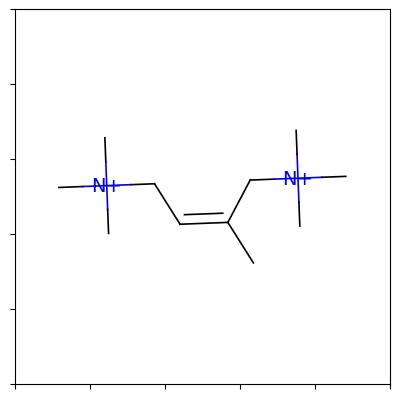

In [23]:
m = Chem.MolFromSmiles(smiles[18299])
fig = Draw.MolToMPL(m, size=(150,150))

In [24]:
list_fn_group_in_mols = [find_list_fn_group(i) for i in mol_graph]
list_total_aromatic_mols = [find_total_aromatic(i) for i in mol_graph]
list_cycle_non_aromatic = [find_total_cycle_non_aromatic(i) for i in mol_graph]

In [25]:
fn_group_dict = {
        "amines" : [('N', 'C', 1), ('N', 'C', 1)],
        "alcohol" : [('O', 'C', 1)],
        "ether" : [('O', 'C', 1), ('O', 'C', 1)],
        "alkyl halide": [('C', 'C', 1), ('C', 'O', 2), ('C', 'C', 1)],
        "thiol": [('S', 'C', 1)],
        "aldehyde": [('C', 'O', 2)],
        "aldehyde2": [('O', 'C', 2)],
        "ketone": [('O', 'C', 1), ('O', 'C', 1)],
        "amides": [('N', 'C', 1), ('N', "O", "2"), ('N', 'C', 1)],
        "sulfide": [('S', 'C', 1), ('S', 'C', 1)],
        "amines2" : [('N', 'C', 1), ('N', 'C', 1), ('N', 'C', 1)],
        "amines3" : [('N', 'C', 1)],
        "carbodiimides" : [('C', 'N', 2), ('C', 'N', 2)],
        "nitrates": [('N', 'O', 1), ('N', 'O', 1), ('N', 'O', 2)],
        "esters": [('C','C', 1), ('C', 'O', 2), ('C', 'O', 1)],
        "haloalkene": [ ('F', 'C', 1)], 
        "haloalkene2": [('Cl', 'C', 1)], 
        "haloalkene3": [('Br', 'C', 1)], 
        "haloalkene4": [('I', 'C', 1)],
        "imine": [('N', 'C', 2), ('N', 'N', 1)],
        "nitro": [('N', 'C', 1), ('N', 'O', 2), ('N', 'O', 1)],
        "cyanide": [('N', 'C', 3)],
        "isocyanate": [('C', 'N', 2), ('C', 'O', 2)],
        "azocompound": [('N', 'N', 2), ('N', 'C', 1)],
        "sulfoxide":[('O', 'S', 2)],
        "azido": [('N', 'N', 2), ('N', 'N', 2)],
        "nitroso": [('N', 'C', 1), ('N', 'O', 2)],
        "phospate": [('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 2)],
        "phospite": [('P', 'O', 1), ('P', 'O', 1), ('P', 'O', 1)],
        "isothio": [('C', 'N', 2), ('C', 'S', 2)],
        "thioamide": [('C', 'N', 1), ('C', 'S', 2)],
        "nitro2": [('N', 'C', 1), ('N', 'O', 2), ('N', 'O', 2)]
    }
list(fn_group_dict.keys())

['amines',
 'alcohol',
 'ether',
 'alkyl halide',
 'thiol',
 'aldehyde',
 'aldehyde2',
 'ketone',
 'amides',
 'sulfide',
 'amines2',
 'amines3',
 'carbodiimides',
 'nitrates',
 'esters',
 'haloalkene',
 'haloalkene2',
 'haloalkene3',
 'haloalkene4',
 'imine',
 'nitro',
 'cyanide',
 'isocyanate',
 'azocompound',
 'sulfoxide',
 'azido',
 'nitroso',
 'phospate',
 'phospite',
 'isothio',
 'thioamide',
 'nitro2']

In [26]:
x = [[i.count(j) for j in list(fn_group_dict.keys())] for i in list_fn_group_in_mols]
new_df = pd.DataFrame(x, columns=list(fn_group_dict.keys()))
new_df["aromatic"] = list_total_aromatic_mols
new_df["cycle"] = list_cycle_non_aromatic
new_df

,amines,alcohol,ether,alkyl halide,thiol,aldehyde,aldehyde2,ketone,amides,sulfide,...,sulfoxide,azido,nitroso,phospate,phospite,isothio,thioamide,nitro2,aromatic,cycle
0,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,2
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62082,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
62083,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
62084,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
62085,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [28]:
new_df["amines"] = new_df["amines"] + new_df["amines2"] + new_df["amines3"]
new_df["aldehyde"] = new_df["aldehyde"] + new_df["aldehyde2"]
new_df["haloalkene"] = new_df["haloalkene"] + new_df["haloalkene2"] + new_df["haloalkene3"] + new_df["haloalkene4"]
new_df["nitro"] = new_df["nitro"] + new_df["nitro2"]
new_df.drop(["amines2", "amines3", "aldehyde2", "haloalkene2", "haloalkene3", "haloalkene4", "nitro2"], axis=1, inplace=True)
new_df

,amines,alcohol,ether,alkyl halide,thiol,aldehyde,ketone,amides,sulfide,carbodiimides,...,azocompound,sulfoxide,azido,nitroso,phospate,phospite,isothio,thioamide,aromatic,cycle
0,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62082,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
62083,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
62084,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
62085,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [27]:
new_df.to_csv("Datas/clear_encoded_data.csv", index=False)

In [ ]:
""" 
List of functional Group:
Benzene ring (-C6H6)
Amine (R-NH-R')
Alcohol (R-OH)
ether (R-O-R')
Alkyl halide (R-CO-R')
Thiol (R-SH)
Aldehyde  (R-COH)
Ketone (R-O-R')
Ester (R-COO-R')
Carboxylic Acid (R-OOH)
Amide (R-ONH-R')
Haloalkane (R-X)
Nitrile (R-CN)
"""